# Preface

In this notebook, we visualize, via contour plots, a randomly-initialized neural network as a function of its inputs, and investigate its dependence on depth.

We current do not have a complete understanding as to why or when deep neural networks have an advantage over shallow ones, but this is an active area of research. Some references on this topic are given below.

    (1) Lu, Z.; Pu, H.; Wang, F.; Hu, Z.; Wang, L. The Expressive Power of Neural Networks: A View from the Width. In Advances in neural information processing systems; 2017; pp 6231–6239.
    (2) Shen, Z.; Yang, H.; Zhang, S. Nonlinear Approximation via Compositions. arXiv preprint arXiv:1902.10170 2019.
    (3) Daubechies, I.; DeVore, R.; Foucart, S.; Hanin, B.; Petrova, G. Nonlinear Approximation and (Deep) ReLU Networks. arXiv:1905.02199 [cs] 2019.
    (4) Shen, Z.; Yang, H.; Zhang, S. Deep Network Approximation Characterized by Number of Neurons. 2019.
    (5) Daws, J.; Webster, C. Analysis of Deep Neural Networks with Quasi-Optimal Polynomial Approximation Rates. arXiv:1912.02302 [cs, math] 2019.

In [17]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale=1.5)
np.random.seed(123)
tf.random.set_seed(123)

# Function to Produce Contour Plot

First, we will write a handy function to plot a 2D contour map of a given function $f$. This can be easily done by the `plt.contourf` function.

In [18]:
def plot_contour(f, x_range=(-10, 10), y_range=(-10, 10), delta=0.1, **contour_kwargs):
    """
    Plots 2D contour of f
        f: a callable that takes input x[:, 2] and returns f(x) of size [:, 1]
    """
    # Get mesh grid
    x = np.arange(*x_range, delta).astype('float32')
    y = np.arange(*y_range, delta).astype('float32')
    X, Y = np.meshgrid(x, y)
    stacked = np.column_stack([X.ravel(), Y.ravel()])
    z_pred = f(stacked)
    Z = z_pred.reshape(X.shape)
    
    # Plot
    plt.contourf(X, Y, Z, **contour_kwargs)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.xticks(np.linspace(*x_range, 5))
    plt.yticks(np.linspace(*y_range, 5))
    plt.colorbar()

# Visualizing a Shallow Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [20]:
shallow_nn = Sequential()
shallow_nn.add(Dense(150, activation='relu', bias_initializer='glorot_normal'))
shallow_nn.add(Dense(1))

1250/1250 [==============================] - 0s 305us/step


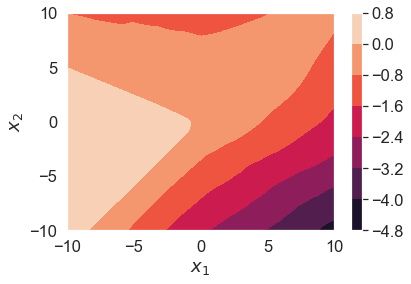

In [22]:
plot_contour(shallow_nn.predict)

We can print a neat summary of our model using the `summary` method. 

This gives a summary of our layers as well as the number of parameters.


**Remark.**
Note that for models created from `Sequential`, because it doesn't know the input shape, you will not be able to print a summary before calling it at least once (either train or inference).

In [23]:
shallow_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (32, 150)                 450       
                                                                 
 dense_21 (Dense)            (32, 1)                   151       
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


# Visualizing Deep Neural Networks

Now, let us instead build a deep neural network consisting of 3 hidden layers, but each layer is narrower than before. Our goal is to see how the landscape may differ.

In [27]:
deep_nn = Sequential()
for _ in range(3):
    deep_nn.add(Dense(units=16, activation='relu', bias_initializer='glorot_normal'))
deep_nn.add(Dense(units=1))

1250/1250 [==============================] - 0s 303us/step


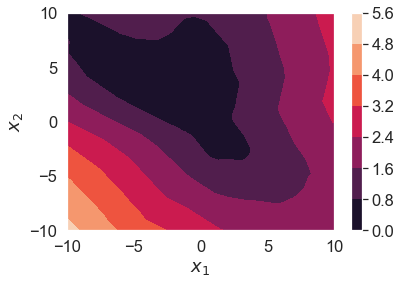

In [28]:
plot_contour(deep_nn.predict)

In [29]:
deep_nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (32, 16)                  48        
                                                                 
 dense_27 (Dense)            (32, 16)                  272       
                                                                 
 dense_28 (Dense)            (32, 16)                  272       
                                                                 
 dense_29 (Dense)            (32, 1)                   17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Observe that a deeper network with a similar number of parameters (i.e. narrow layers) seems to have a more "rugged" landscape. This is a commonly observed, and is what makes deep networks sometimes hard to train.

We can go even deeper.

In [10]:
deep_nn = Sequential()
for _ in range(6):
    deep_nn.add(Dense(units=10, activation='relu', bias_initializer='glorot_normal'))
deep_nn.add(Dense(units=1))

1250/1250 [==============================] - 0s 320us/step


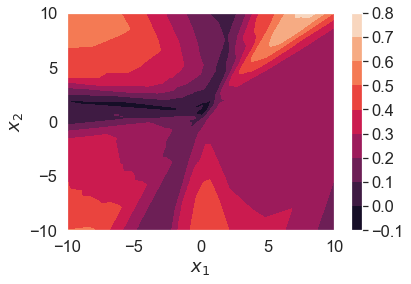

In [11]:
plot_contour(deep_nn.predict)

In [12]:
deep_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (32, 10)                  30        
                                                                 
 dense_7 (Dense)             (32, 10)                  110       
                                                                 
 dense_8 (Dense)             (32, 10)                  110       
                                                                 
 dense_9 (Dense)             (32, 10)                  110       
                                                                 
 dense_10 (Dense)            (32, 10)                  110       
                                                                 
 dense_11 (Dense)            (32, 10)                  110       
                                                                 
 dense_12 (Dense)            (32, 1)                  

# A Residual Network

One of the key recent innovation which made deep models competitive is the invention of the residual network [1]. Here, instead of the connection
$$
    h^{(i+1)} = f^{(i)}(h^{(i)}, \theta^{(i)})
$$
we replace them by
$$
    h^{(i+1)} = h^{(i)} + f^{(i)}(h^{(i)}, \theta^{(i)})
$$
Note: this has important connection to differential equations and numerical analysis, e.g. see [2], [3].

We will test this variant of deep networks. We will also take this opportunity to introduce an alternative model API to `Sequential`. This is known as the [functional API](https://keras.io/getting-started/functional-api-guide/) and is one of the most flexible way to build models. The reason why `Sequential()` is not easily applied here is that the $i+1$ layer is connected to both the activation of the previous layer, as well as the outputs from the previous $f^{(i)}$.


**Remark.**
The most flexible way is actually model-subclassing, but it does sacrifice certain useful features, such as serialization. For more information, see [documentation](https://keras.io/models/about-keras-models/).

Note that for models created from `Sequential`, because it doesn't know the input shape, you will not be able to print a summary before calling it at least once (either train or inference).

References:

    [1] He, K.; Zhang, X.; Ren, S.; Sun, J. Deep Residual Learning for Image Recognition. CoRR 2015, abs/1512.0. https://doi.org/10.1109/CVPR.2016.90.
    [2] Li, Q.; Chen, L.; Tai, C.; E, W. Maximum Principle Based Algorithms for Deep Learning. The Journal of Machine Learning Research 2017, 18 (1), 5998–6026.
    [3] E, W.; Han, J.; Li, Q. A Mean-Field Optimal Control Formulation of Deep Learning. Research in the Mathematical Sciences 2019, 6 (1), 10.


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add

In [14]:
x = Input(shape=(2, ))  # For the functional API we will need the input layer
dense_layer = Dense(units=10, activation='tanh', bias_initializer='glorot_normal')
h = dense_layer(x)
for _ in range(5):
    dense_layer = Dense(units=10, activation='relu', bias_initializer='glorot_normal')
    add_layer = Add()
    f = dense_layer(h)
    h = add_layer([h, f])
output_layer = Dense(units=1)
y_hat = output_layer(h)

residual_nn = Model(inputs=x, outputs=y_hat)

In [15]:
residual_nn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 10)           30          ['input_1[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 10)           110         ['dense_13[0][0]']               
                                                                                                  
 add (Add)                      (None, 10)           0           ['dense_13[0][0]',               
                                                                  'dense_14[0][0]']           

1250/1250 [==============================] - 0s 341us/step


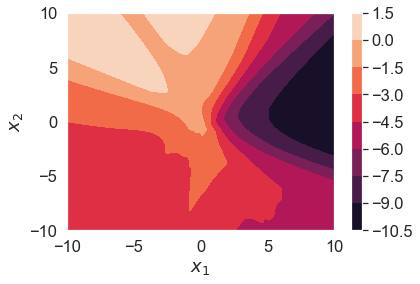

In [16]:
plot_contour(residual_nn.predict)

# Exercise

Train each of these networks on some dataset of your choice.
  * Which has the best expressive power?
  * Which is the easiest to train?